<div class="alert alert-info"><h1>Industrial Accident Causal Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords, wordnet
from nltk import tokenize, stem
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
import re
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Amin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<div class="alert alert-info"><h2>Preprocess Data for further analysis

In [3]:
# Function to convert Months to Seasons
def month2season(x):
    if x in [9, 10, 11]:
        season = 'spring'
    elif x in [12, 1, 2]:
        season = 'summer'
    elif x in [3, 4, 5]:
        season = 'autumn'
    else:
        season = 'winter'
    return season

In [4]:
data = pd.read_csv('with_description.csv').copy()
df = pd.DataFrame(data)
df = df.drop(columns=['Unnamed: 0'])
df = df.rename(columns={
    'Data': 'date', 
    'Countries': 'country', 
    'Industry Sector': 'sector', 
    'Genre': 'gender', 
    'Employee or Third Party': 'employment',
    'Critical Risk': 'risk',
    'Description': 'description',
    'Accident Level': 'level',
    'Potential Accident Level': 'potential',
    'Local': 'local'
    })

# convert to datetime and map categories
df['date'] = pd.to_datetime(df['date'])
df['potential'] = df['potential'].map({"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5, "VI": 6})
df['level'] = df['level'].map({"I": 1, "II": 2, "III": 3, "IV": 4, "V": 5})


# separate year / month / day
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].apply(lambda x: x.day_name())

# add seasons
df['season'] = df['month'].apply(month2season)


df.head()

,date,country,local,sector,level,potential,gender,employment,risk,description,year,month,day,weekday,season
0,2016-01-01,Country_01,Local_01,Mining,1,4,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,2016,1,1,Friday,summer
1,2016-01-02,Country_02,Local_02,Mining,1,4,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,2016,1,2,Saturday,summer
2,2016-01-06,Country_01,Local_03,Mining,1,3,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,2016,1,6,Wednesday,summer
3,2016-01-08,Country_01,Local_04,Mining,1,1,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,2016,1,8,Friday,summer
4,2016-01-10,Country_01,Local_04,Mining,4,4,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,2016,1,10,Sunday,summer


In [5]:
colors = sns.color_palette("deep")
colors

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

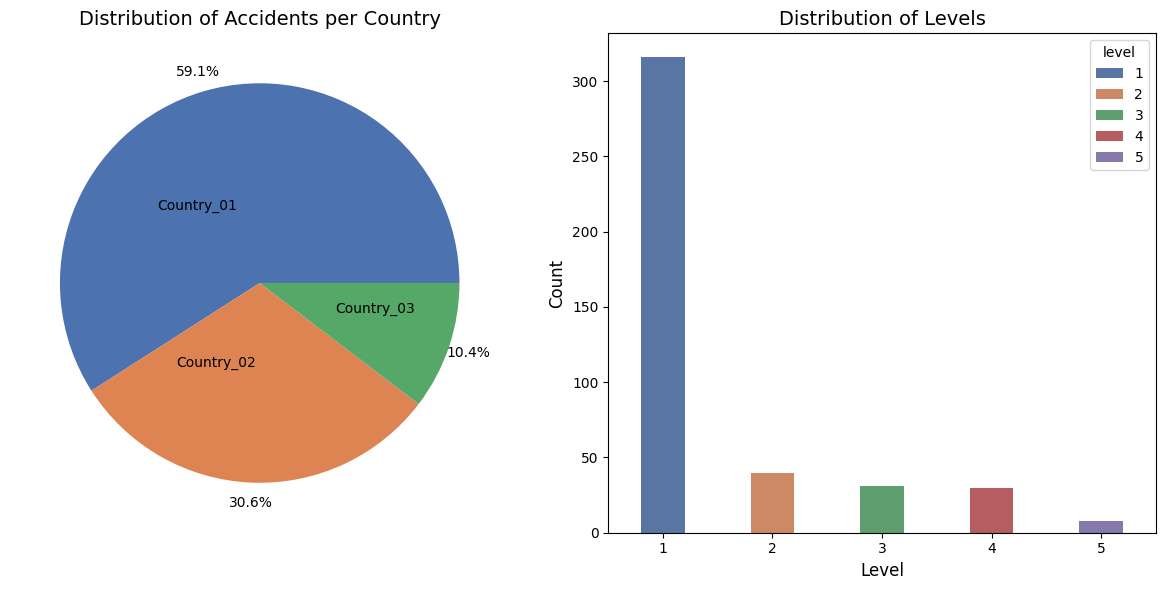

In [6]:

countries = df['country'].value_counts()
levels = df['level'].value_counts().reset_index()
levels.columns = ['level', 'count']

fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 Zeile, 2 Spalten

# Plot 1: Pie
axes[0].pie(
    countries, 
    labels=countries.index, 
    colors=colors, 
    autopct="%1.1f%%", 
    pctdistance=1.1, 
    labeldistance=0.4
)
axes[0].set_title("Distribution of Accidents per Country", fontsize=14)

# Plot 2: Bar
sns.barplot(data=levels, x='level', y='count',hue='level', palette='deep', ax=axes[1], width=.4)
axes[1].set_title("Distribution of Levels", fontsize=14)
axes[1].set_xlabel("Level", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)

# Layout optimieren
plt.tight_layout()
plt.show()


<div class="alert alert-info"><h3>NLTK Analysis of Descriptions

In [7]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-zA-Z0-9\s]', "", text)
    text = re.sub(r'\s+', " ", text).strip()

    tokens = word_tokenize(text)
    
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatizing
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    return ' '.join(lemmatized)

df['cleaned_description'] = df['description'].apply(clean_text)


<div class="alert alert-info"><h3> Sentiment Analysis of Descriptions

In [8]:
def sentiment2score(text):
    analyzer = SentimentIntensityAnalyzer()
    sent_score = analyzer.polarity_scores(text)['compound']
    return float(sent_score)

In [9]:
df['sentScoreDesc'] = df['cleaned_description'].apply(lambda x: sentiment2score(x))

In [10]:
df['sentScoreDesc'].head()

0    0.8834
1    0.2732
2    0.4939
3    0.0772
4   -0.4215
Name: sentScoreDesc, dtype: float64

<div class="alert alert-info"><h3><u>Analyze Unigrams / Bigrams / Trigrams </h3></u>
<p><b><i>Note</i></b><br>Many Words are related to each other (n-grams). Example: right hand, left hand, finger left hand, finger right hand, ...

In [40]:
def ngrams(ngram, trg='', trg_value=''):
    if (trg == '') or (trg_value == ''):
        string_filtered = df['cleaned_description'].sum().split()

    else:
        string_filtered = df[df[trg].isin(trg_value)]['cleaned_description'].sum().split()
    dic = nltk.FreqDist(nltk.ngrams(string_filtered, ngram)).most_common(20)
    ngram_df = pd.DataFrame(dic, columns=['ngram', 'count'])
    ngram_df.index = [' '.join(i) for i in ngram_df.ngram]
    ngram_df.drop('ngram', axis=1, inplace=True)
    return ngram_df



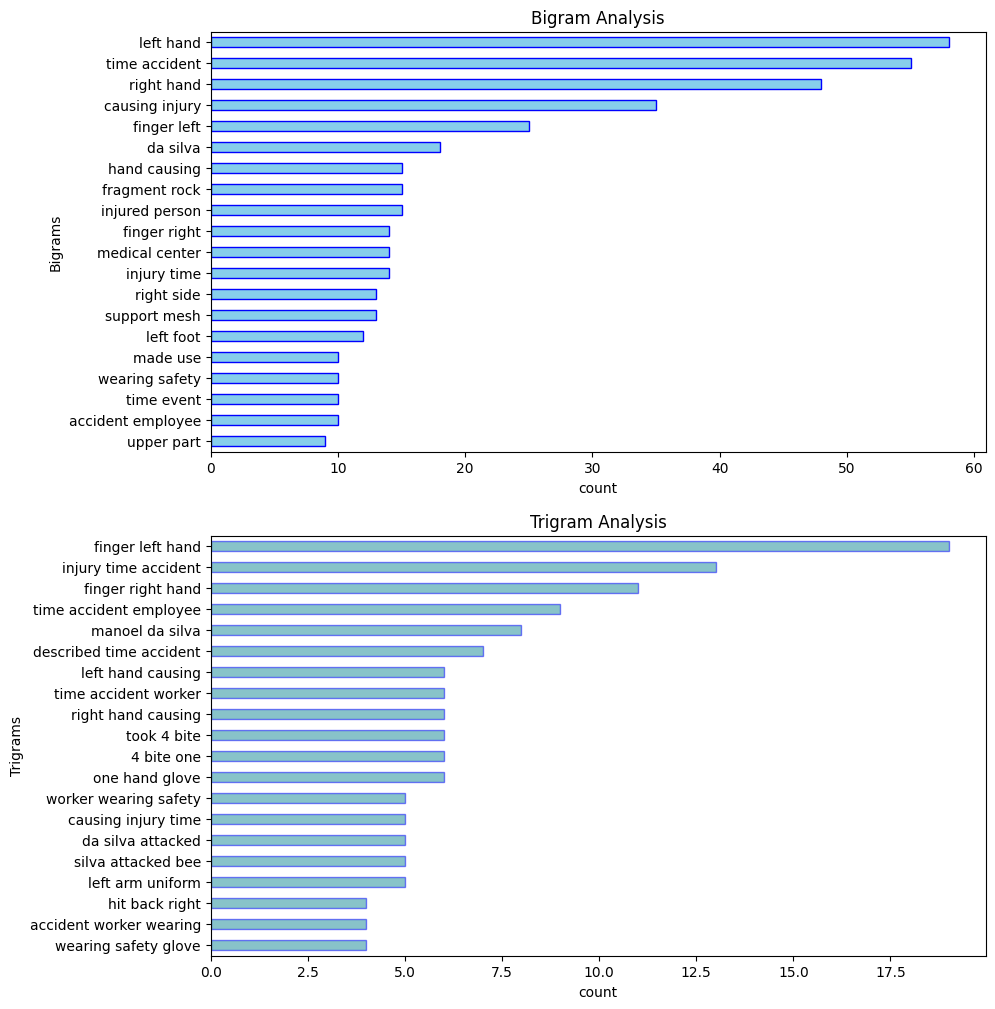

In [55]:
bigrams = ngrams(2)[::-1]
trigrams = ngrams(3)[::-1]

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

bigrams.plot(
    kind='barh', 
    color='skyblue', 
    edgecolor='blue', 
    legend=None,
    ax = ax[0]
    )

ax[0].set_title("Bigram Analysis")
ax[0].set_xlabel("count")
ax[0].set_ylabel("Bigrams")



trigrams.plot(
    kind='barh', 
    color='#138895',
    alpha=0.5,
    edgecolor='blue', 
    legend=None,
    ax = ax[1]
    )

ax[1].set_title("Trigram Analysis")
ax[1].set_xlabel("count")
ax[1].set_ylabel("Trigrams")

plt.show()


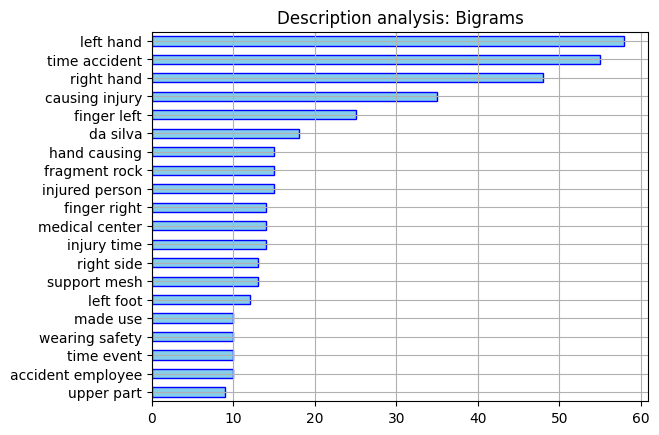

In [52]:
bigrams = ngrams(2)[::-1]
bigrams.plot(kind='barh', color='skyblue', edgecolor='blue', legend=None)
plt.title("Description analysis: Bigrams")
plt.grid()
plt.show()